# Data Scientist - Code Challenge

### Author:Harry Han
### Email: harryhancanada@hotmail.com

We need to predict the demand for the next 24 hours by utilizing past electricity demand data points, humidity, temperature, dew point, and other drivers like weekdays, holidays, and etc.

#### Inputs:

- sample data.csv is attached.


### Output:

A 24-hour demand forecast for a sample day in July or August.

  
## General Requirements
- The data set may contain outliers and abnormal values.
- This is everything you need to know about having a better development experience.
- Write an instruction to run the project.
- Don’t commit the .vscode or .idea directory.

### Evaluation:

- The work will be evaluated based on the accuracy of the electricity demand forecast, the clarity of the code and documentation, and the overall effectiveness of the solution.
- The acceptable error rate must be less than 5% (AE < 500 MW, or accuracy more than 95%)
  
### Deliverables for the Code Challenge

- Detailed Report: Provide a comprehensive report covering model selection, fine-tuning processes, evaluation metrics, and results.
- Code and Documentation: Include all code and documentation necessary to reproduce the experiments and results.

### Submission
- Please submit a GitHub link with your work and fork the repository for collaboration.
- You have 1 week to send the challenge!




# 0. Import Libraries and read data

In [2]:
#install necessary libraries
!pip install skforecast
!pip install shap

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from statsmodels.regression import linear_model
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import datetime
import os
import IPython
import IPython.display
import plotly.graph_objects as go

from pylab import rcParams
import matplotlib as mpl
from matplotlib import rc
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
from lightgbm import LGBMRegressor

from sklearn.feature_selection import RFECV


data = pd.read_csv("/content/drive/MyDrive/Edgecom/data.csv") # replace the file location
holiday = pd.read_csv("/content/drive/MyDrive/Edgecom/holidays.csv") # replace the file location

In [4]:
data.head()

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station
0,2016-01-01,Friday,0,0.49,14023,-0.3,-5.62,20,-3.18,70,-5.1,99.67
1,2016-01-01,Friday,1,-1.09,13417,-0.3,-6.30,25,-3.48,68,-5.5,99.63
2,2016-01-01,Friday,2,-2.41,12968,-0.4,-6.55,26,-3.43,73,-4.7,99.59
3,2016-01-01,Friday,12,0.00,14215,-2.1,-8.72,23,-4.86,76,-5.8,99.39
4,2016-01-01,Friday,13,0.00,14443,-2.4,-8.23,19,-5.09,84,-4.7,99.35


In [5]:
data.tail()

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station
39403,2020-12-31,Thursday,19,36.85,17384,0.2,-4.02,13,-2.69,74,-3.8,100.66
39404,2020-12-31,Thursday,20,19.69,16783,-0.2,-5.59,16,-3.58,65,-6.0,100.76
39405,2020-12-31,Thursday,21,20.78,16154,-3.0,-7.44,12,-3.67,80,-6.0,100.81
39406,2020-12-31,Thursday,22,27.85,15744,-0.8,-6.76,17,-4.11,70,-5.6,100.90
39407,2020-12-31,Thursday,23,19.68,15092,-2.1,-6.21,11,-4.72,73,-6.2,100.90


In [6]:
holiday.head()

,date,holiday
0,2012-01-02,New Year's Day
1,2012-02-20,Family Day
2,2012-04-06,Good Friday
3,2012-05-21,Victoria Day
4,2012-07-02,Canada Day


In [7]:
# Using dataframe holiyday: left join data with holiday on date

data = data.merge(holiday, left_on='Date', right_on='date', how='left')
data.drop(['date'], axis=1, inplace=True)
data['holiday'] = data['holiday'].notnull()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39408 entries, 0 to 39407
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               39408 non-null  object 
 1   Weekday            39408 non-null  object 
 2   Hour               39408 non-null  int64  
 3   HOEP               39408 non-null  float64
 4   Ontario_Demand     39408 non-null  int64  
 5   Temperature        39408 non-null  float64
 6   Windchill_Index    39408 non-null  float64
 7   Wind_Speed         39408 non-null  int64  
 8   Humidex            39408 non-null  float64
 9   Relative_Humidity  39408 non-null  int64  
 10  Dew_Point          39408 non-null  float64
 11  Pressure_Station   39408 non-null  float64
 12  holiday            39408 non-null  bool   
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 3.6+ MB


In [8]:

data.head()

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station,holiday
0,2016-01-01,Friday,0,0.49,14023,-0.3,-5.62,20,-3.18,70,-5.1,99.67,True
1,2016-01-01,Friday,1,-1.09,13417,-0.3,-6.30,25,-3.48,68,-5.5,99.63,True
2,2016-01-01,Friday,2,-2.41,12968,-0.4,-6.55,26,-3.43,73,-4.7,99.59,True
3,2016-01-01,Friday,12,0.00,14215,-2.1,-8.72,23,-4.86,76,-5.8,99.39,True
4,2016-01-01,Friday,13,0.00,14443,-2.4,-8.23,19,-5.09,84,-4.7,99.35,True


### Data descriptions:

*   Date,Weekday,Hour: Date and Time range of the data (2016-01-01 - 2020-12-31 24 hour data)

*   HOEP: Hourly Ontario Energy Price

*   Ontario_Demand: Electricity demand in Ontario, measured in MW

*   Temperature: Temperature in Celsius

*   Windchill_Index: Windchill is a measure of how cold it feels when exposed to cold temperatures and wind.

*   Wind_Speed: The rate at which air is moving horizontally past a given point. It may be a 2-minute average speed (reported as wind speed) or an instantaneous speed (reported as a peak wind speed, wind gust, or squall).

*   Humidex:The humidex (short for humidity index) is an index number used by Canadian meteorologists to describe how hot the weather feels to the average person, by combining the effect of heat and humidity.

*   Relative_Humidity:Relative humidity, often expressed as a percentage, indicates a present state of absolute humidity relative to a maximum humidity given the same temperature.

*   Dew_Point: The dew point is the temperature the air needs to be cooled to (atconstant pressure) in order to achieve a relative humidity (RH) of 100%.

*   Pressure_Station: This is the pressure that is observed at a specific elevation and is the true barometric pressure of a location.

*   Holiday: Whether it is holiday in ontario




# Data Quality Check

## General Check

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39408 entries, 0 to 39407
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               39408 non-null  object 
 1   Weekday            39408 non-null  object 
 2   Hour               39408 non-null  int64  
 3   HOEP               39408 non-null  float64
 4   Ontario_Demand     39408 non-null  int64  
 5   Temperature        39408 non-null  float64
 6   Windchill_Index    39408 non-null  float64
 7   Wind_Speed         39408 non-null  int64  
 8   Humidex            39408 non-null  float64
 9   Relative_Humidity  39408 non-null  int64  
 10  Dew_Point          39408 non-null  float64
 11  Pressure_Station   39408 non-null  float64
 12  holiday            39408 non-null  bool   
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 3.6+ MB


In [10]:
data.describe()

,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station
count,39408.000000,39408.000000,39408.000000,39408.000000,39408.000000,39408.000000,39408.000000,39408.000000,39408.000000,39408.000000
mean,11.625076,13.923340,15397.914205,9.421272,6.565978,16.854243,9.859521,68.028598,3.330397,99.533605
std,6.945136,11.902378,2201.241563,10.899602,13.513148,9.220125,14.325742,16.773789,10.269080,0.776696
min,0.000000,-2.770000,9831.000000,-26.000000,-39.660000,0.000000,-31.100000,13.000000,-31.600000,96.490000
25%,6.000000,3.300000,13775.000000,0.800000,-3.950000,10.000000,-1.680000,57.000000,-4.400000,99.050000
50%,12.000000,12.950000,15272.000000,8.600000,5.670000,16.000000,7.860000,69.000000,3.000000,99.540000
75%,18.000000,22.510000,16881.000000,19.000000,18.580000,22.000000,22.350000,81.000000,12.100000,100.040000
max,23.000000,44.110000,24281.000000,35.100000,37.940000,80.000000,50.350000,100.000000,25.100000,102.410000


**The data has non null rows, but seems it do not have all the data points for every hour/day from 2016-2020 as the Hour mean should be 11.50 if all hours data exist. So we need to check if it has missing data points or duplicates as well**


## Check missing dates

In [11]:
# Create a list of all dates from 2016-01-01 to 2020-12-31
date_range = pd.date_range(start='2016-01-01', end='2020-12-31')

# Convert the date range to a list of strings
date_range_str = date_range.strftime('%Y-%m-%d').tolist()

# Find the dates that are not in the data
missing_dates = set(date_range_str) - set(data['Date'].tolist())

# Print the missing dates
print(missing_dates)
# Print the total days

print(date_range.size)

set()
1827


**No missing dates**

## Check missing hours

In [12]:

# Find the unique dates in the dataset
unique_dates = data['Date'].unique()

# Create a list of all possible hours in a day
all_hours = list(range(24))

# Initialize an empty list to store the missing hours for each date
missing_hours = []

# Loop through each date in the dataset
for date in unique_dates:
  # Get the hours present for that date
  hours_present = data[data['Date'] == date]['Hour'].tolist()

  # Find the missing hours by comparing the two lists
  missing_hours.append([hour for hour in all_hours if hour not in hours_present])

# Get the total count of missing hours, and the percentage of all data we supposed to have
total_missing_hours = sum([len(hours) for hours in missing_hours])
total_expected_hours = len(date_range) * 24
missing_percentage = total_missing_hours / total_expected_hours * 100

print(f"Total missing hours: {total_missing_hours}")
print(f"Percentage of missing data: {missing_percentage:.2f}%")



Total missing hours: 4443
Percentage of missing data: 10.13%


**We have found some missing hours, which is around 10%**

## Check Duplicates Date/Hour Entries

In [13]:
data[data.duplicated(subset=["Hour", "Date"], keep=False)]


,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station,holiday
21809,2018-11-04,Sunday,1,0.00,13148,1.3,-2.84,10,-1.07,79,-2.0,100.66,False
21810,2018-11-04,Sunday,1,13.30,12507,0.9,-2.33,9,-0.62,81,-1.9,100.77,False
29467,2019-11-03,Sunday,1,2.80,13032,1.1,-2.80,13,-0.61,91,-0.2,99.40,False
29468,2019-11-03,Sunday,1,-0.01,12221,1.1,-3.93,18,-1.07,92,0.0,99.41,False
37970,2020-11-01,Sunday,1,0.00,13085,5.4,2.50,12,3.91,74,1.1,99.48,False
37971,2020-11-01,Sunday,1,-0.07,11800,6.7,2.93,11,5.18,74,2.3,99.35,False


**We have found some duplicates, 3 duplicates for this three dates**

# Preprocessing

## Drop Duplicate Entries

In [14]:
# Drop Duplicates by keeping the first one (assume the first one is correct)
data = data.drop_duplicates(subset=['Hour', 'Date'], keep='first')

In [15]:
# Check duplicates again
data[data.duplicated(subset=["Hour", "Date"], keep=False)]


,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station,holiday


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39405 entries, 0 to 39407
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               39405 non-null  object 
 1   Weekday            39405 non-null  object 
 2   Hour               39405 non-null  int64  
 3   HOEP               39405 non-null  float64
 4   Ontario_Demand     39405 non-null  int64  
 5   Temperature        39405 non-null  float64
 6   Windchill_Index    39405 non-null  float64
 7   Wind_Speed         39405 non-null  int64  
 8   Humidex            39405 non-null  float64
 9   Relative_Humidity  39405 non-null  int64  
 10  Dew_Point          39405 non-null  float64
 11  Pressure_Station   39405 non-null  float64
 12  holiday            39405 non-null  bool   
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 3.9+ MB


## Preprocessing date columns

In [17]:
# Add month and year to data, use date and hour for index
df = data.copy()

df['Date'] = pd.to_datetime(df['Date'])
# Convert 'Hour' column to integer and ensure it's two digits
df['Hour'] = df['Hour'].astype(int).astype(str).str.zfill(2) # Convert to integer first, then to string

# Combine 'Date' and 'Hour' correctly
df['Date_Hour'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Hour'], format="%Y-%m-%d %H")
df.set_index('Date_Hour', inplace=True) # Make sure to set 'Date_Hour' as index
df.sort_values(by='Date_Hour', inplace=True)
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Qtr'] = df.index.quarter
df.drop(['Date'], axis=1, inplace=True)


# covert weekday names into weekday number into same format
df['Weekday']= df['Weekday'].replace({'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6})
df.head()


,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station,holiday,Month,Year,Qtr
Date_Hour,,,,,,,,,,,,,,,
2016-01-01 00:00:00,4,00,0.49,14023,-0.3,-5.62,20,-3.18,70,-5.1,99.67,True,1,2016,1
2016-01-01 01:00:00,4,01,-1.09,13417,-0.3,-6.30,25,-3.48,68,-5.5,99.63,True,1,2016,1
2016-01-01 02:00:00,4,02,-2.41,12968,-0.4,-6.55,26,-3.43,73,-4.7,99.59,True,1,2016,1
2016-01-01 12:00:00,4,12,0.00,14215,-2.1,-8.72,23,-4.86,76,-5.8,99.39,True,1,2016,1
2016-01-01 13:00:00,4,13,0.00,14443,-2.4,-8.23,19,-5.09,84,-4.7,99.35,True,1,2016,1


## Add missing hours to smooth the data

In [18]:
# Add missing hours we find
df_m = df.copy()

# Convert unique_dates to a list
unique_dates_list = unique_dates.tolist()  # Convert to a list

# Loop through each date in the unique_dates list
for date in unique_dates_list: # Iterate over the list
  # Get the missing hours for that date
  missing_hours_for_date = missing_hours[unique_dates_list.index(date)]

  # Create a DataFrame for the missing hours
  missing_hours_df = pd.DataFrame({
    'Date': [date] * len(missing_hours_for_date),
    'Hour': missing_hours_for_date,
    'Weekday': datetime.datetime.strptime(date, '%Y-%m-%d').weekday(),
    'Month': datetime.datetime.strptime(date, '%Y-%m-%d').month,
    'Year': datetime.datetime.strptime(date, '%Y-%m-%d').year,
    'Qtr': (datetime.datetime.strptime(date, '%Y-%m-%d').month - 1) // 3 + 1 , # Calculate quarter
    'holiday': data.loc[data['Date']==date]['holiday'].values[0]


    # Convert date string to datetime object before calling weekday()
  })
  # Convert 'Date' column to datetime objects
  missing_hours_df['Date'] = pd.to_datetime(missing_hours_df['Date'])

  missing_hours_df['Date_Hour'] = pd.to_datetime(missing_hours_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + missing_hours_df['Hour'].astype(str), format="%Y-%m-%d %H")

  missing_hours_df.set_index('Date_Hour', inplace=True)
  missing_hours_df.drop(['Date'], axis=1, inplace=True)

  # Concatenate the missing hours DataFrame with the original DataFrame
  df_m = pd.concat([df_m, missing_hours_df], ignore_index=False)


In [19]:
categorical_features = ['Weekday','Hour','Month','Year','Qtr','holiday']
target = ['Ontario_Demand']
numerical_features = df.columns.difference(categorical_features).difference(target).values.tolist()
print('Categorical varaibles:',categorical_features)
print('Numerical varaibles:',numerical_features)
print('Target varaibles:',target)

Categorical varaibles: ['Weekday', 'Hour', 'Month', 'Year', 'Qtr', 'holiday']
Numerical varaibles: ['Dew_Point', 'HOEP', 'Humidex', 'Pressure_Station', 'Relative_Humidity', 'Temperature', 'Wind_Speed', 'Windchill_Index']
Target varaibles: ['Ontario_Demand']


In [20]:
# Convert 'Hour' column to numeric, coercing errors to NaN
df_m['Hour'] = pd.to_numeric(df_m['Hour'], errors='coerce')

# Fill missing numerical values with mean by Hour,Weekday, and Month from 2016-2020
for col in numerical_features + target:
  df_m[col] = df_m.groupby(['Hour','Weekday','Month'])[col].transform(lambda x: x.fillna(x.mean()))


In [21]:
# Convert the index to a consistent datetime type
df_m.index = pd.to_datetime(df_m.index)

# Now sort the DataFrame by index
df_m.sort_index(inplace=True)
df_m.head()

,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station,holiday,Month,Year,Qtr
Date_Hour,,,,,,,,,,,,,,,
2016-01-01 00:00:00,4,0,0.490000,14023.000000,-0.300000,-5.620000,20.000000,-3.180000,70.000000,-5.100000,99.670000,True,1,2016,1
2016-01-01 01:00:00,4,1,-1.090000,13417.000000,-0.300000,-6.300000,25.000000,-3.480000,68.000000,-5.500000,99.630000,True,1,2016,1
2016-01-01 02:00:00,4,2,-2.410000,12968.000000,-0.400000,-6.550000,26.000000,-3.430000,73.000000,-4.700000,99.590000,True,1,2016,1
2016-01-01 03:00:00,4,3,9.841053,14384.421053,-4.031579,-9.796316,18.263158,-6.969474,74.789474,-7.931579,99.606316,True,1,2016,1
2016-01-01 04:00:00,4,4,10.420000,14317.952381,-3.757143,-9.521429,18.142857,-6.629524,75.476190,-7.547619,99.573333,True,1,2016,1


In [22]:

# Now check the hour counts
df_m['Hour'].value_counts().sort_index()

Hour
0     1827
1     1827
2     1827
3     1827
4     1827
5     1827
6     1827
7     1827
8     1827
9     1827
10    1827
11    1827
12    1827
13    1827
14    1827
15    1827
16    1827
17    1827
18    1827
19    1827
20    1827
21    1827
22    1827
23    1827
Name: count, dtype: int64

**There is no missing data points**

# 2. EDA

In [23]:
df_eda = df_m.copy()

## Add Moving Average

In [24]:
# add day,week,month,quater,year moving average
df_eda[["movave_day", "movstd_day"]] = df_eda['Ontario_Demand'].rolling(24).agg([np.mean, np.std])
df_eda[["movave_week", "movstd_week"]] = df_eda['Ontario_Demand'].rolling(24*7).agg([np.mean, np.std])
df_eda[["movave_month", "movstd_month"]] =  df_eda['Ontario_Demand'].rolling(24*30).agg([np.mean, np.std])
df_eda[["movave_qtr", "movstd_qtr"]] =  df_eda['Ontario_Demand'].rolling(24*90).agg([np.mean, np.std])
df_eda[["movave_year", "movstd_year"]] = df_eda['Ontario_Demand'].rolling(24*365).agg([np.mean, np.std])

## Skewness Analysis

In [25]:
from  scipy.stats import skew, kurtosis, shapiro


mean = np.mean(df_eda['Ontario_Demand'].values)
std = np.std(df_eda['Ontario_Demand'].values)
skew = skew(df_eda['Ontario_Demand'].values)
ex_kurt = kurtosis(df_eda['Ontario_Demand'])
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.30544069280288094 
Kurtosis: 2.677739598510535


Positive Skewness:Not completelly simetric and has a right tail

Kurtosis below 3: It means that tails are slightly thinner than in a Normal distribution. It is said that the distribution is platykurtic and the chance of finding extre values is lower than in a normal distribution.

In [26]:
def shapiro_test(data, alpha=0.05):
    stat, pval = shapiro(data)
    print("H0: Data was drawn from a Normal Distribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))

shapiro_test(df_eda['Ontario_Demand'], alpha=0.05)

H0: Data was drawn from a Normal Distribution
pval 0.0 is lower than significance level: 0.05, therefore null hypothesis is rejected


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Data is not normally distributed**

## Target Analysis

<ipython-input-27-c2cbb0eb454e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_eda['Ontario_Demand'])


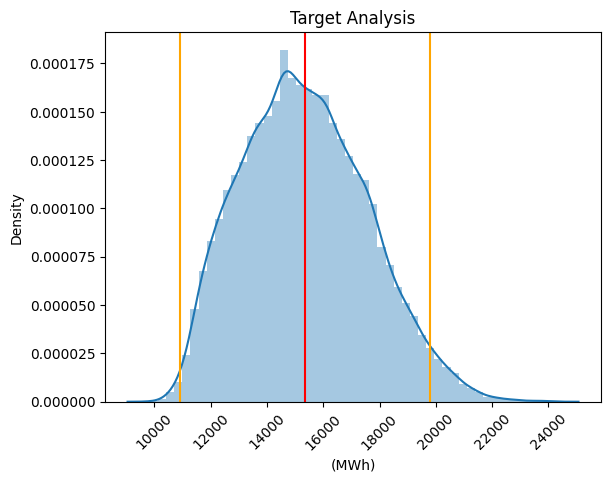

In [27]:
sns.distplot(df_eda['Ontario_Demand'])
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

### Average Demand by Month and Year

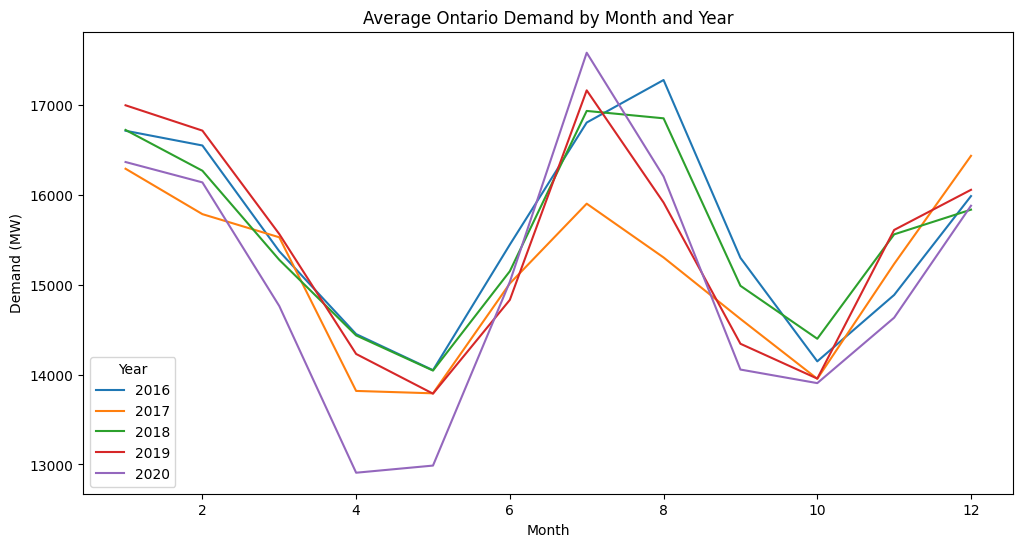

In [28]:
#  Plot line plot for average 'Ontario_Demand' by month and year
df_monthly = df_eda.groupby(['Month','Year'])['Ontario_Demand'].mean().unstack()
df_monthly.plot(kind='line',figsize=(12,6))
plt.title('Average Ontario Demand by Month and Year')
plt.ylabel('Demand (MW)')
plt.show()


## Volatility Analysis

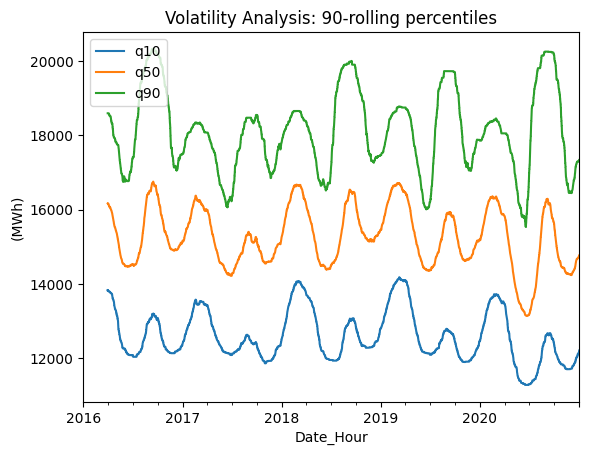

In [29]:
# Insert the rolling quantiles to the monthly returns
data_rolling =df_eda['Ontario_Demand'].rolling(window=2160)

# Plot the rolling quantiles for the monthly returns
df_eda['q10'] = data_rolling.quantile(0.1).to_frame("q10")
df_eda['q50'] = data_rolling.quantile(0.5).to_frame("q50")
df_eda['q90'] = data_rolling.quantile(0.9).to_frame("q90")

df_eda[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

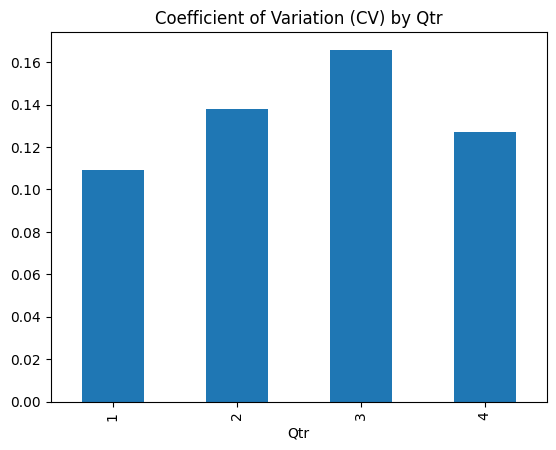

In [30]:
df_eda.groupby("Qtr")["Ontario_Demand"].std().divide(df_eda.groupby("Qtr")["Ontario_Demand"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by Qtr")
plt.show()

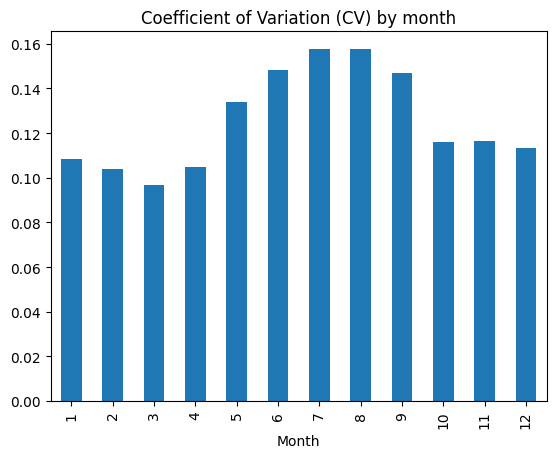

In [31]:
df_eda.groupby("Month")["Ontario_Demand"].std().divide(df_eda.groupby("Month")["Ontario_Demand"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

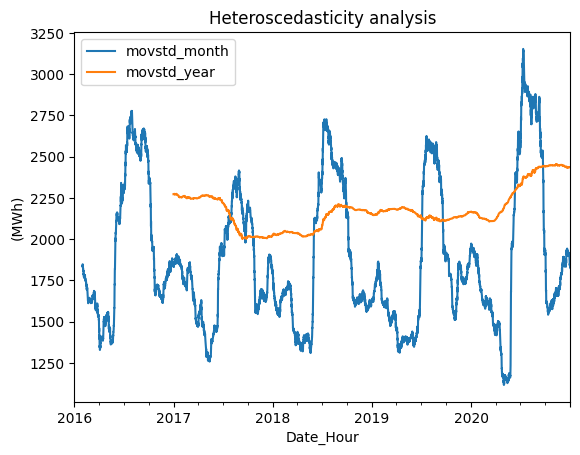

In [32]:
df_eda[["movstd_month", "movstd_year"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

**In the short term (quaterly and monthly) volatility is changeable, but in the long term (year window) it is stable, therefore, candidate predictors will have to deal with seasonal pattern in variance.**

**We notice that There are big and small peaks in ever year around, Jan-Feb, July-Aug, and December, there is some seasonality**


## Time Series Analysis: Seasonality and Trend


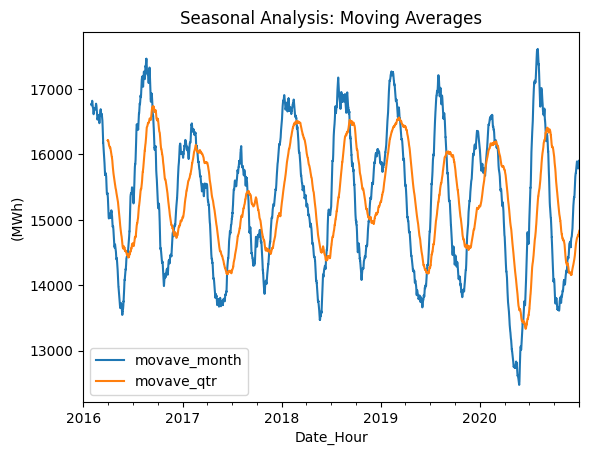

In [33]:
df_eda[["movave_month", "movave_qtr"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

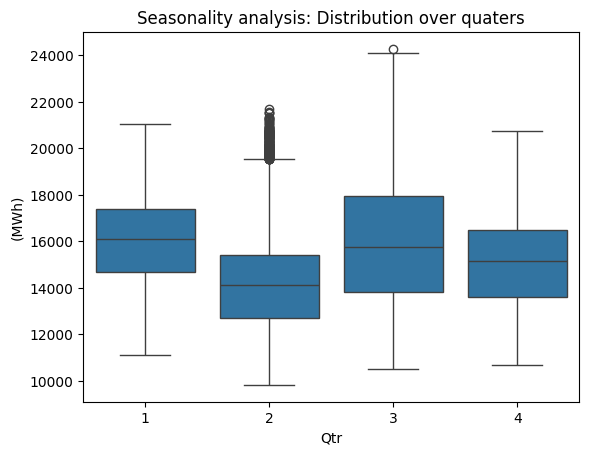

In [34]:
sns.boxplot(data=df_eda, x="Qtr", y="Ontario_Demand")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

**There is a clear seasonal pattern in quaterters, Qtr 2**


### Trend Analysis

In [35]:
# Convert the index to datetime if it's not already
df_eda.index = pd.to_datetime(df_eda.index)

data_mon = df_eda['Ontario_Demand'].resample("M").agg(sum).to_frame('Ontario_Demand')
data_mon["ix"] = range(0, len(data_mon))
data_mon.head()

,Ontario_Demand,ix
Date_Hour,,
2016-01-31,1.243591e+07,0
2016-02-29,1.151947e+07,1
2016-03-31,1.143786e+07,2
2016-04-30,1.040480e+07,3
2016-05-31,1.045299e+07,4


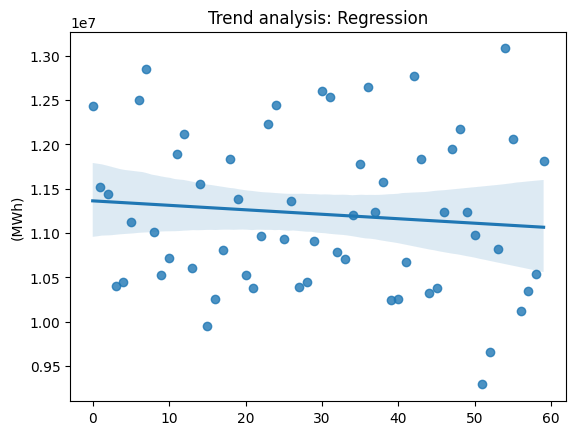

In [36]:
sns.regplot(data=data_mon,x="ix", y="Ontario_Demand")
plt.title("Trend analysis: Regression")
plt.ylabel("(MWh)")
plt.xlabel("")
plt.show()

**A sligtly drop from 2016- 2020 in regression analysis, but not significant**

### Autocorrelation plots


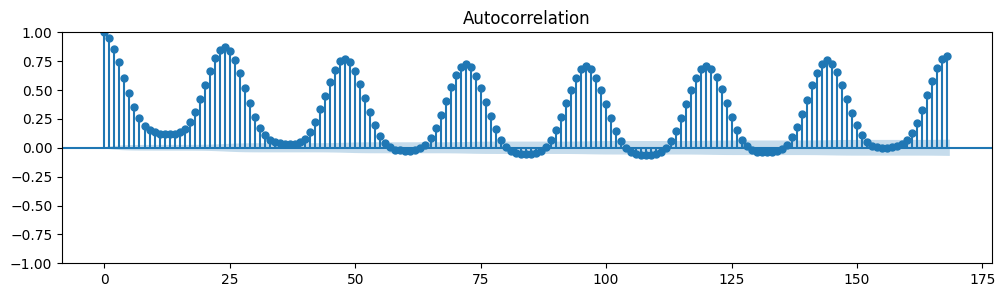

In [37]:
# Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


fig, ax = plt.subplots(figsize=(12, 3))
plot_acf(df_eda['Ontario_Demand'], ax=ax, lags=168)
plt.show()

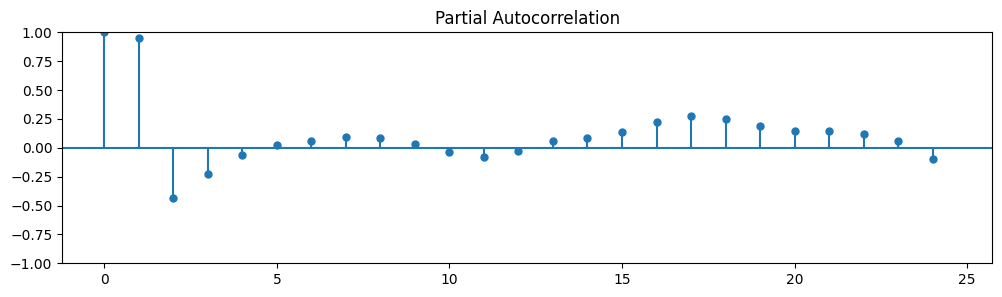

In [38]:
# Partial autocorrelation plot

fig, ax = plt.subplots(figsize=(12, 3))
plot_pacf(df_eda['Ontario_Demand'], ax=ax, lags=24)
plt.show()

**The autocorrelation plot demonstrates a strong correlation between demand in hours, as well as between demand in one hour and the corresponding hour in preceding days. This observed correlation suggests that autoregressive models may be effective in this scenario**

## Categorical Distribution Analysis

### Weekday Distribution

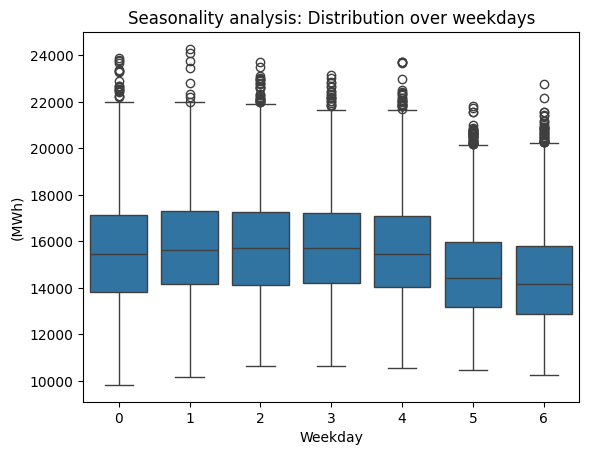

In [39]:
sns.boxplot(data=df_eda, x="Weekday", y="Ontario_Demand")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

**As expected, on weekends(5,6) the demand is lower than normal days (0 is Monday)**

### Annual Distribution

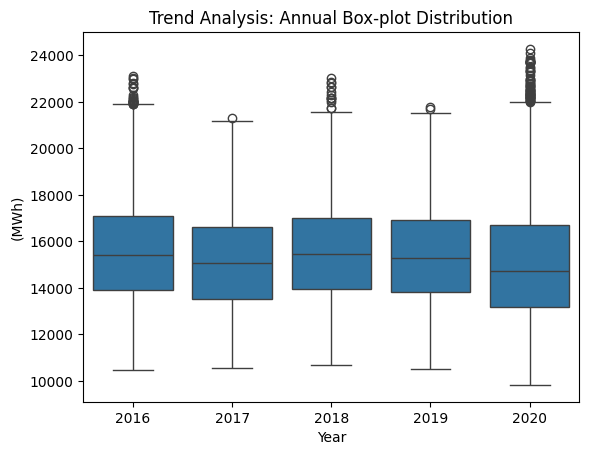

In [40]:
sns.boxplot(data=df_eda, x="Year", y="Ontario_Demand")
plt.title("Trend Analysis: Annual Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()


**There is no significant trend in annual distribution, we could see more extreme values but lower mean value in 2020 that covid started.**

### Hour Distribution

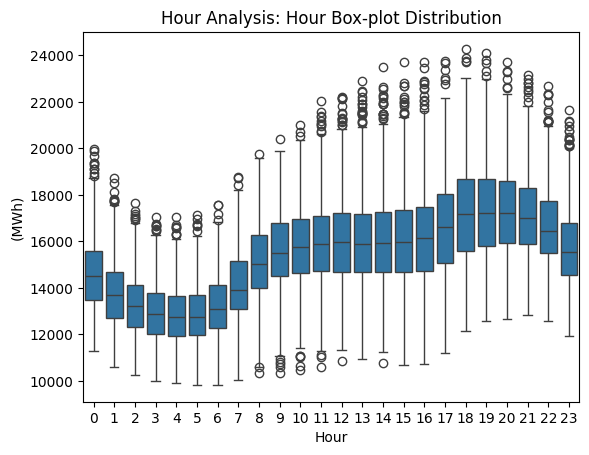

In [41]:
sns.boxplot(data=df_eda, x="Hour", y="Ontario_Demand")
plt.title("Hour Analysis: Hour Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()


**As expected,There is clear trend in hour distribution**

### Holiday Distribution

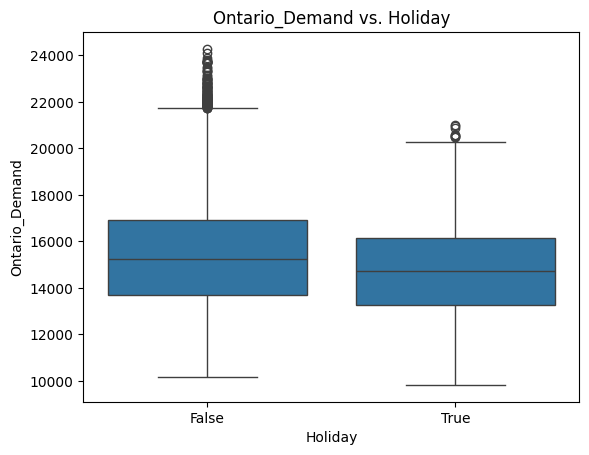

In [42]:


# Create a boxplot of Ontario_Demand grouped by holiday
sns.boxplot(x="holiday", y="Ontario_Demand", data=df_eda)

# Add title and labels
plt.title("Ontario_Demand vs. Holiday")
plt.xlabel("Holiday")
plt.ylabel("Ontario_Demand")

# Show the plot
plt.show()


**Holiday tends to have lower demand which make sense that people tends to travel more in holidays, this might be a good feature to predict demand**

## Numerical Analysis

#### Correlation Heat Map for Numerical Features

<Axes: >

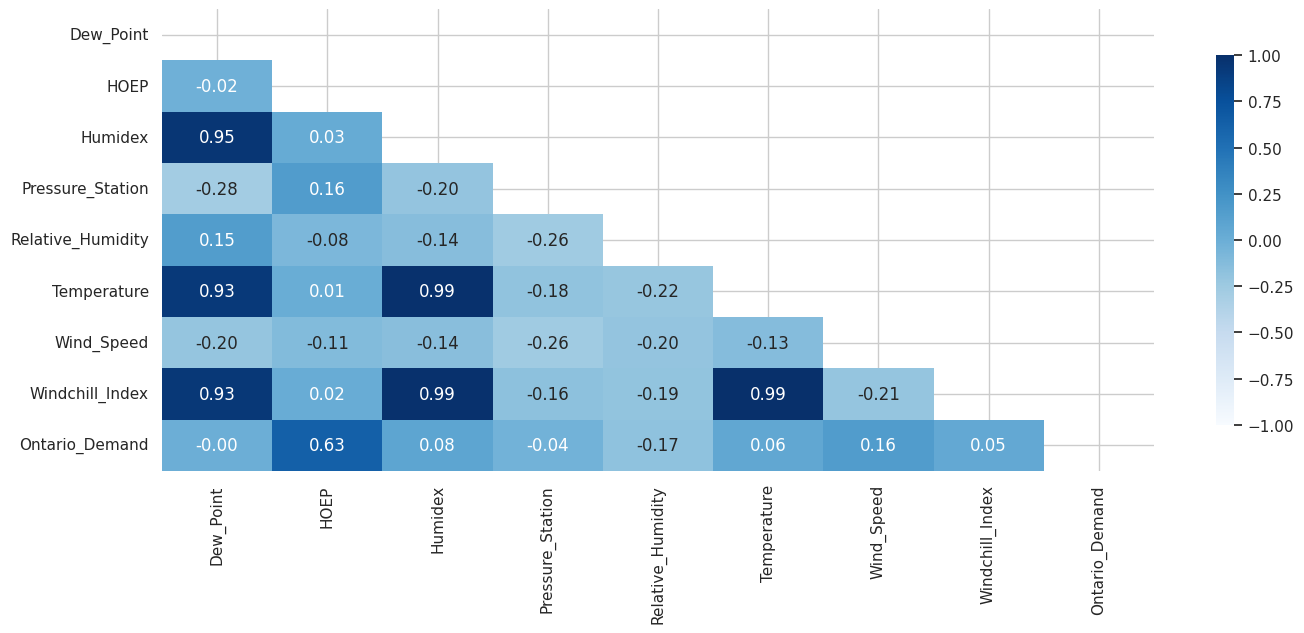

In [43]:

# Setup environment
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
# set styles
register_matplotlib_converters()
# set seaborn style
sns.set(style='whitegrid', palette='muted', font_scale=1)
# set plotting parameters
rcParams['figure.figsize'] = 16, 6


# get correlations for numerical features
df_corr = df_eda[numerical_features+target].corr()
# create mask
mask = np.triu(np.ones_like(df_corr, dtype=bool)) # Use the built-in bool type
# plot heatmap
sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
            vmin=-1, vmax=1, cbar_kws={"shrink": .8})

**HOEP is the top main  factors to determin the electricity demand which makes sense that people tends to save money.**

**Temperature, Windchill_index, humidex and Dew_Point are highly correlated, which makes sense all these are temperature related data.**

#### Boxplots for numerical features

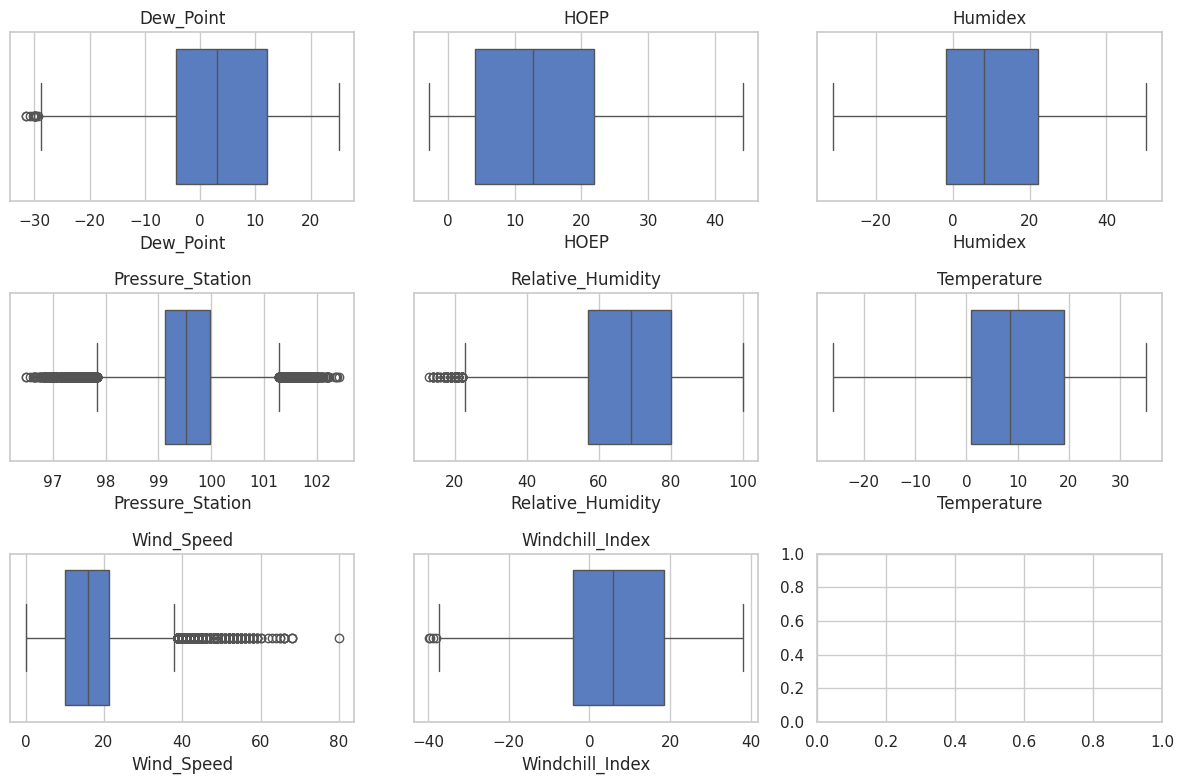

In [44]:
# Plot box plots for all numerical features in 3x3 matrix
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

# Plot boxplots for each numerical feature
for i, feature in enumerate(numerical_features):
  row = i // 3
  col = i % 3
  sns.boxplot(x=df_eda[feature], ax=axes[row, col])
  axes[row, col].set_title(feature)

# Adjust spacing and show plot
plt.tight_layout()
plt.show()


**We notice there is abnormal and outliers in Dew_Point,Pressure_Station, Relaive_Humidity,Wind_Speed, and Windchill_Index columns but these features are not highly co-related to our target variable, we can test if we need to replace these abnormal and outliers values**


# Models



Build some simple models with what we have now that can be used as a reference to assess whether more complex models are worth implementing.

## Simple Models for comparison ##

In [45]:
# Convert 'Date' to datetime object and extract features
df_f= df_m.copy()

X = df_f.drop(target, axis=1)  # Drop the original 'Date' column
y = df_f[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical = categorical_features
numerical = df_f.drop(categorical, axis=1).drop(target,axis=1).columns.tolist()

# Create transformers for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train different regression models
models = [
    LinearRegression(),
    Ridge(alpha=0.1),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1),
]

for model in models:
    # Create a pipeline to combine preprocessing and model training
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{model.__class__.__name__}: MAE = {mae} MW')
    print(f'{model.__class__.__name__}: MAPE = {mape*100 }%')

# Select the best model based on MSE
best_model_pipeline = min([Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]) for model in models], key=lambda pipeline: mean_squared_error(y_test, pipeline.predict(X_test)))



LinearRegression: MAE = 695.4065798034485 MW
LinearRegression: MAPE = 4.53490416489821%
Ridge: MAE = 695.4648699186456 MW
Ridge: MAPE = 4.535134900118579%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 556748123.3264694, tolerance: 17309621.256108597
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso: MAE = 695.7236784278455 MW
Lasso: MAPE = 4.535950902049835%
ElasticNet: MAE = 987.2324087648296 MW
ElasticNet: MAPE = 6.493720149440149%


**Best Simple Model: LinearRegression MAE = 695.4065798034485 MW MAPE = 4.53490416489821%**

## Build Models
Based on the exploratory analysis performed, the model will be the one that predicts each hour using the value of the same hour on the previous day.

In [46]:
# Split data into train-val-test 8-1-1 ratio
end_train = '2019-12-31 23:59:00'
end_validation = '2020-06-30 23:59:00'
df_m = df_m.asfreq('H')
data_train = df_m.loc[: end_train, :].copy()
data_val   = df_m.loc[end_train:end_validation, :].copy()
data_test  = df_m.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2016-01-01 00:00:00 --- 2019-12-31 23:00:00  (n=35064)
Validation dates : 2020-01-01 00:00:00 --- 2020-06-30 23:00:00  (n=4368)
Test dates       : 2020-07-01 00:00:00 --- 2020-12-31 23:00:00  (n=4416)


### Basemodel: Forecaster Equivalent Date Model

In [47]:
# Model use value of the same hour of the previous day

forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=1),
                 n_offsets = 1
             )

# Train forecaster

forecaster.fit(y=df_m.loc[:end_validation, 'Ontario_Demand'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2020-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Creation date: 2024-07-10 23:55:01 
Last fit date: 2024-07-10 23:55:01 
Skforecast version: 0.12.1 
Python version: 3.10.12 
Forecaster id: None 

In [48]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_m['Ontario_Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(df_m.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error (MAPE): {metric}")

  0%|          | 0/184 [00:00<?, ?it/s]

Backtest error (MAPE): 0.051261078552838055


### Build recursive autoregression model

#### Recursive multi-step forecasting

A recursive autoregressive model ForecasterAutoreg is trained using a gradient boosting regressor LGBMRegressor as the base regressor. A time window of 24 hours (24 lags) is used to predict the next hour's demand. This means that the demand values of the previous 24 hours are used as predictors. The hyperparameters of the underlying regressor are left at their default values.


In [49]:
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=42, verbose=-1),
                 lags      = 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_m.loc[:end_validation, 'Ontario_Demand'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=42, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2020-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 


#### Backtesting

To obtain a robust estimate of the model's predictive ability, a backtesting process is performed. The backtesting process consists of generating a forecast for each observation in the test set, following the same procedure as would be done in production, and then comparing the predicted value to the actual value.

In [50]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_m['Ontario_Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(df_m.loc[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 39432
Number of observations used for backtesting: 4416
    Number of folds: 184
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2016-01-01 00:00:00 -- 2020-06-30 23:00:00  (n=39432)
    Validation: 2020-07-01 00:00:00 -- 2020-07-01 23:00:00  (n=24)
Fold: 1
    Training:   2016-01-01 00:00:00 -- 2020-06-30 23:00:00  (n=39432)
    Validation: 2020-07-02 00:00:00 -- 2020-07-02 23:00:00  (n=24)
Fold: 2
    Training:   2016-01-01 00:00:00 -- 2020-06-30 23:00:00  (n=39432)
    Validation: 2020-07-03 00:00:00 -- 2020-07-03 23:00:00  (n=24)
Fold: 3
    Training:   2016-01-01 00:00:00 -- 2020-06-30 23:00:00  (n=39432)
    Validation: 2020-07-04 00:00:00 -- 2020-07-04 23:00:00  (n=24)
Fold: 4
    Training:   2016-01-01 00:00:00 -- 2020-06-30 23:00:00  (n=39432)
    Validation: 2020-07-

  0%|          | 0/184 [00:00<?, ?it/s]

#### Predictions vs Real Value

In [51]:
# Plot predictions vs real value
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Ontario_Demand'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Ontario Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [52]:
# Backtesting error
# ==============================================================================
print(f'Backtest error (MAPE): {metric}')

Backtest error (MAPE): 0.0476497979422561


### Hyperparameter tuning


In [53]:
# Hyperparameters search

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24, # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_m.loc[:end_validation, 'Ontario_Demand'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_percentage_error',
                                   search_space       = search_space,
                                   initial_train_size = len(df_m[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.20213758391513376, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.8}
  Backtesting metric: 0.04947430290103498



In [54]:
# Search results
results_search.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,lags,params,mean_absolute_percentage_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 6, 'learni...",0.049474,1000.0,6.0,0.202138,0.3,0.8
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 700, 'max_depth': 5, 'learnin...",0.049671,700.0,5.0,0.145675,0.0,0.3
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 800, 'max_depth': 8, 'learnin...",0.049709,800.0,8.0,0.055131,0.4,0.4
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 600, 'max_depth': 4, 'learnin...",0.050085,600.0,4.0,0.205234,0.3,1.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1100, 'max_depth': 8, 'learni...",0.050802,1100.0,8.0,0.309402,0.7,0.3


In [55]:
# Best model
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.20213758391513376, max_depth=6, n_estimators=1000,
              random_state=15926, reg_alpha=0.30000000000000004, reg_lambda=0.8,
              verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2020-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.20213758391513376, 'max_depth': 6, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': No

### Backtesting on test data

In [56]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_m['Ontario_Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(df_m[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.6f}")
predictions.head()

  0%|          | 0/184 [00:00<?, ?it/s]

Backtest error: 0.045585


,pred
2020-07-01 00:00:00,16400.749337
2020-07-01 01:00:00,15147.547931
2020-07-01 02:00:00,14600.235290
2020-07-01 03:00:00,13783.150334
2020-07-01 04:00:00,13507.531760


**After optimization of lags and hyperparameters, the prediction error was notably reduced to 4.5585%**



### Remove outliers

Here we can test if outliers removed will improve the performance

In [57]:
df_f = df_m.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [58]:
# Loop through each numerical feature and target
for col in target+numerical_features:
  # Calculate the interquartile range (IQR)
  Q1 = np.percentile(df_f[col], 25, interpolation='midpoint')
  Q3 = np.percentile(df_f[col], 75, interpolation='midpoint')
  IQR = Q3 - Q1

  # Define the lower and upper bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers and abnormal values
  outliers = df_f[~((df_f[col] >= lower_bound) & (df_f[col] <= upper_bound))]

  # Print information about outliers and abnormal values
  print(f"Outliers and abnormal values for '{col}':")
  print(f"Number of outliers: {len(outliers)}")
  print(f"Outliers: {outliers[col].to_list()}")

Outliers and abnormal values for 'Ontario_Demand':
Number of outliers: 126
Outliers: [21903.0, 21924.0, 22044.0, 22659.0, 22600.0, 22216.0, 22012.0, 21806.0, 22024.0, 22005.0, 21865.0, 21732.0, 21711.0, 21900.0, 21926.0, 21807.0, 21929.0, 22008.0, 22587.0, 22754.0, 23039.0, 23100.0, 22986.0, 22804.0, 22055.0, 22175.0, 22095.0, 21698.0, 22011.0, 21801.0, 22279.0, 22106.0, 21817.0, 21963.0, 21736.0, 21761.0, 22158.0, 22446.0, 22631.0, 22805.0, 22872.0, 23046.0, 22177.0, 22177.0, 22017.0, 22104.0, 22646.0, 22294.0, 21716.0, 21791.0, 21861.0, 22150.0, 22457.0, 22315.0, 22050.0, 21862.0, 22433.0, 22522.0, 22306.0, 21981.0, 22256.0, 22001.0, 22212.0, 23451.0, 23753.0, 24281.0, 24100.0, 22820.0, 22321.0, 22119.0, 22912.0, 23499.0, 22791.0, 22932.0, 23724.0, 22992.0, 22330.0, 22195.0, 23179.0, 22682.0, 23719.0, 23735.0, 23670.0, 23704.0, 22972.0, 22353.0, 21826.0, 22158.0, 22400.0, 22032.0, 21752.0, 21828.0, 22777.0, 22155.0, 21815.0, 22459.0, 22273.0, 22679.0, 23909.0, 23685.0, 23307.0, 22424

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



#### Replace Outliers with Mean value group by Month,Weekday,Hour

In [59]:
# Replace Outliers value with mean values by month,weekday and hour
df_clean = df_f.copy()
for col in target+numerical_features:
  # Calculate the mean value for each month, weekday, and hour
  mean_values = df_clean.groupby(['Month','Weekday','Hour'])[col].mean()

  # Replace outliers and abnormal values with the corresponding mean values
  df_clean[col] = df_clean.apply(lambda row: mean_values[row['Month'], row['Weekday'], row['Hour']] if row[col] < lower_bound or row[col] > upper_bound else row[col], axis=1)


#### Check if there are outliers after replacing

In [60]:
# Loop through each numerical feature and target
for col in target+numerical_features:
  # Calculate the interquartile range (IQR)
  Q1 = np.percentile(df_clean[col], 25, interpolation='midpoint')
  Q3 = np.percentile(df_clean[col], 75, interpolation='midpoint')
  IQR = Q3 - Q1

  # Define the lower and upper bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers and abnormal values
  outliers = df_clean[~((df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound))]

  # Print information about outliers and abnormal values
  print(f"Outliers and abnormal values for '{col}':")
  print(f"Number of outliers: {len(outliers)}")
  print(f"Outliers: {outliers[col].to_list()}")

Outliers and abnormal values for 'Ontario_Demand':
Number of outliers: 0
Outliers: []
Outliers and abnormal values for 'Dew_Point':
Number of outliers: 12
Outliers: [-30.9, -31.6, -31.5, -29.8, -29.3, -29.9, -29.9, -30.0, -30.3, -29.9, -29.9, -29.9]
Outliers and abnormal values for 'HOEP':
Number of outliers: 0
Outliers: []
Outliers and abnormal values for 'Humidex':
Number of outliers: 0
Outliers: []
Outliers and abnormal values for 'Pressure_Station':
Number of outliers: 811
Outliers: [100.11857142857143, 100.17190476190476, 100.2205, 100.22318181818181, 100.244, 100.22399999999999, 100.1435, 100.20095238095237, 100.15571428571428, 100.0990909090909, 100.09095238095237, 100.15499999999999, 100.13000000000001, 100.146, 100.11095238095237, 100.17818181818183, 100.17681818181818, 100.24190476190478, 100.215, 100.284375, 100.30736842105263, 100.31941176470588, 100.20947368421052, 100.19882352941177, 100.215, 100.24000000000001, 100.3235294117647, 100.46, 100.37944444444446, 100.34, 100.2

**There are still some outliers that means they are useful information since we already use group mean to replace them**

### Backtesting on data without outliers

In [61]:
# Hyperparameters search
df_clean = df_clean.asfreq('H')
data_train_clean = df_clean.loc[: end_train, :].copy()
data_val_clean   = df_clean.loc[end_train:end_validation, :].copy()
data_test_clean  = df_clean.loc[end_validation:, :].copy()

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_clean.loc[:end_validation, 'Ontario_Demand'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_percentage_error',
                                   search_space       = search_space,
                                   initial_train_size = len(df_clean[:end_train]),
                                   refit              = False,
                                   n_trials           = 20, # Increase for more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2, 3, 23, 24, 25, 47, 48, 49) which is of type tuple.



`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.20213758391513376, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.8}
  Backtesting metric: 0.00820368740666153



In [62]:
# Best model
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.20213758391513376, max_depth=6, n_estimators=1000,
              random_state=15926, reg_alpha=0.30000000000000004, reg_lambda=0.8,
              verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-01-01 00:00:00'), Timestamp('2020-06-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.20213758391513376, 'max_depth': 6, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': No

In [63]:
# Backtest final model on test data with outliers removed

metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_clean['Ontario_Demand'],
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(df_clean[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to True to see detailed information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.6f}")
predictions.head()

  0%|          | 0/184 [00:00<?, ?it/s]

Backtest error: 0.007347


,pred
2020-07-01 00:00:00,14494.581256
2020-07-01 01:00:00,13575.437540
2020-07-01 02:00:00,12958.976850
2020-07-01 03:00:00,12517.304308
2020-07-01 04:00:00,12271.126747


**The error significantly dropped from 4.5% to 0.7%**

## Forecasting with exogenous variables


### Create Exogenous variables from holiday and temperature

In [64]:

# Holiday features
# ==============================================================================
holiday_features = df_clean[['holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['holiday'].shift(-24)
holiday_features = holiday_features.drop(columns="holiday")
holiday_features.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,holiday_previous_day,holiday_next_day
Date_Hour,,
2016-01-01 00:00:00,NaN,0.0
2016-01-01 01:00:00,NaN,0.0
2016-01-01 02:00:00,NaN,0.0
2016-01-01 03:00:00,NaN,0.0
2016-01-01 04:00:00,NaN,0.0


In [65]:

# Temperature features
# ==============================================================================
temp_features = df_clean[['Temperature']].copy()
temp_features['temp_roll_mean_1_day'] = temp_features['Temperature'].rolling(24, closed='left').mean()
temp_features['temp_roll_mean_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').mean()
temp_features['temp_roll_max_1_day'] = temp_features['Temperature'].rolling(24, closed='left').max()
temp_features['temp_roll_min_1_day'] = temp_features['Temperature'].rolling(24, closed='left').min()
temp_features['temp_roll_max_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').max()
temp_features['temp_roll_min_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').min()
temp_features = temp_features.drop(columns="Temperature")
temp_features.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day
Date_Hour,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# Merge all exogenous variables
# ==============================================================================
exogenous_features = pd.concat([
                         df_clean[categorical_features],
                         df_clean[numerical_features],
                         temp_features,
                         holiday_features
                     ], axis=1)

exogenous_features.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Weekday,Hour,Month,Year,Qtr,holiday,Dew_Point,HOEP,Humidex,Pressure_Station,...,Wind_Speed,Windchill_Index,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day
Date_Hour,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,4,0,1,2016,1,True,-5.100000,0.490000,-3.180000,99.586190,...,20.000000,-5.620000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-01-01 01:00:00,4,1,1,2016,1,True,-5.500000,-1.090000,-3.480000,99.559545,...,25.000000,-6.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-01-01 02:00:00,4,2,1,2016,1,True,-4.700000,-2.410000,-3.430000,99.564091,...,26.000000,-6.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-01-01 03:00:00,4,3,1,2016,1,True,-7.931579,9.841053,-6.969474,99.606316,...,18.263158,-9.796316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Create Cliclical Features

 The use of trigonometric functions such as sine and cosine transformations makes it possible to represent cyclic patterns and avoid inconsistencies in data representation. This approach is known as cyclic encoding and can significantly improve the predictive ability of models.

In [67]:
# Cliclical encoding of date features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

quarter_encoded = cyclical_encoding(exogenous_features['Qtr'], cycle_length=4)
month_encoded = cyclical_encoding(exogenous_features['Month'], cycle_length=12)
week_day_encoded = cyclical_encoding(exogenous_features['Weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(exogenous_features['Hour'], cycle_length=24)

cyclical_features = pd.concat([
    quarter_encoded,
    month_encoded,week_day_encoded,
    hour_day_encoded
                    ], axis=1)

exogenous_features = pd.concat([exogenous_features, cyclical_features], axis=1)
exogenous_features.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Weekday,Hour,Month,Year,Qtr,holiday,Dew_Point,HOEP,Humidex,Pressure_Station,...,holiday_previous_day,holiday_next_day,Qtr_sin,Qtr_cos,Month_sin,Month_cos,Weekday_sin,Weekday_cos,Hour_sin,Hour_cos
Date_Hour,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,4,0,1,2016,1,True,-5.1,0.49,-3.18,99.586190,...,NaN,0.0,1.0,6.123234e-17,0.5,0.866025,-0.433884,-0.900969,0.000000,1.000000
2016-01-01 01:00:00,4,1,1,2016,1,True,-5.5,-1.09,-3.48,99.559545,...,NaN,0.0,1.0,6.123234e-17,0.5,0.866025,-0.433884,-0.900969,0.258819,0.965926
2016-01-01 02:00:00,4,2,1,2016,1,True,-4.7,-2.41,-3.43,99.564091,...,NaN,0.0,1.0,6.123234e-17,0.5,0.866025,-0.433884,-0.900969,0.500000,0.866025


In [68]:
# Interaction between exogenous variables
# ==============================================================================
from sklearn.preprocessing import PolynomialFeatures

transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'Month_sin',
    'Month_cos',
    'Qtr_sin',
    'Qtr_cos',
    'Weekday_sin',
    'Weekday_cos',
    'Hour_sin',
    'Hour_cos',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)
exogenous_features.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Weekday,Hour,Month,Year,Qtr,holiday,Dew_Point,HOEP,Humidex,Pressure_Station,...,poly_temp_roll_mean_7_day__temp_roll_max_1_day,poly_temp_roll_mean_7_day__temp_roll_min_1_day,poly_temp_roll_mean_7_day__temp_roll_max_7_day,poly_temp_roll_mean_7_day__temp_roll_min_7_day,poly_temp_roll_max_1_day__temp_roll_min_1_day,poly_temp_roll_max_1_day__temp_roll_max_7_day,poly_temp_roll_max_1_day__temp_roll_min_7_day,poly_temp_roll_min_1_day__temp_roll_max_7_day,poly_temp_roll_min_1_day__temp_roll_min_7_day,poly_temp_roll_max_7_day__temp_roll_min_7_day
Date_Hour,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,4,0,1,2016,1,True,-5.100000,0.490000,-3.180000,99.586190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,4,1,1,2016,1,True,-5.500000,-1.090000,-3.480000,99.559545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,4,2,1,2016,1,True,-4.700000,-2.410000,-3.430000,99.564091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,4,3,1,2016,1,True,-7.931579,9.841053,-6.969474,99.606316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
exogenous_features.info()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2016-01-01 00:00:00 to 2020-12-31 23:00:00
Freq: H
Columns: 150 entries, Weekday to poly_temp_roll_max_7_day__temp_roll_min_7_day
dtypes: bool(1), float64(144), int64(5)
memory usage: 50.2 MB


### Merge add split

In [70]:
# Merge target and exogenous variables in the same DataFrame
# ==============================================================================
df_e = df_clean[['Ontario_Demand']].merge(
           exogenous_features,
           left_index=True,
           right_index=True,
           how='left'
       )

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. Due to holiday_next_day there are missing values at the end.
df_e = df_e.dropna()
df_e = df_e.astype('float32')

# Split data into train-val-test
df_e_train = df_e.loc[: end_train, :].copy()
df_e_val   = df_e.loc[end_train:end_validation, :].copy()
df_e_test  = df_e.loc[end_validation:, :].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Build Model with exogenous variables

Best Regressor: LGBMRegressor(learning_rate=0.20213758391513376, max_depth=6, n_estimators=1000,
              random_state=15926, reg_alpha=0.30000000000000004, reg_lambda=0.8,
              verbose=-1)

In [71]:
# Create forecaster
# ==============================================================================
params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.20213758391513376,
    'reg_alpha':0.30000000000000004,
    'reg_lambda': 0.8,
    'random_state': 15926,
    'verbose': -1
}
forecaster_e = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [72]:
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_e['Ontario_Demand'],
                          exog               = df_e.drop(columns=['Ontario_Demand']),
                          steps              = 24,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(df_e[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.6f}")
predictions.head()

  0%|          | 0/183 [00:00<?, ?it/s]

Backtest error: 0.005453


,pred
2020-07-01 00:00:00,15651.840300
2020-07-01 01:00:00,14759.959198
2020-07-01 02:00:00,13883.254526
2020-07-01 03:00:00,13604.658231
2020-07-01 04:00:00,13199.307398


**The inclusion of exogenous variables as predictors further improves the MAPE of the model from 0.8% to 0.5%**

## Model explanaibility



In [73]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24
             )
exog_columns = df_e.drop(columns=['Ontario_Demand']).columns.tolist()
forecaster.fit(
    y    = df_e.loc[:end_validation, 'Ontario_Demand'],
    exog = df_e.loc[:end_validation, exog_columns ]
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [74]:
# Model-specific feature importances
# ==============================================================================
feature_importances = forecaster.get_feature_importances()
feature_importances.sort_values(by='importance', ascending=False).head(15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,feature,importance
0,lag_1,1024
33,Pressure_Station,863
23,lag_24,635
22,lag_23,608
31,HOEP,553
21,lag_22,498
1,lag_2,490
5,lag_6,466
4,lag_5,461
34,Relative_Humidity,456


### Feature Selection
We can run a  Recursive Feature Elimination, due to time issue, I will skip it.

In [75]:
selected_features = exog_columns

# Prediction with Gap

So far, we have evaluated the model under the assumption that the forecasts for the next day are generated at exactly 11:59 PM each day. However, this approach is impractical because there is no time to manage the early hours of the next day.

In [76]:
# Backtesting with gap
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(**params),
                 lags      = 24,
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_e['Ontario_Demand'],
                          exog                  = df_e[selected_features],
                          steps                 = 24,
                          metric                = 'mean_absolute_percentage_error',
                          initial_train_size    = len(df_e.loc[:end_validation])+12,
                          gap                   = 12, # Number of positions to skip
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

print("")
print(f"Backtest error (MAPE): {metric:.6f}")

  0%|          | 0/182 [00:00<?, ?it/s]


Backtest error (MAPE): 0.007080


**As expected, the error sligtly increases as we add gap.**

In [77]:
# Forecast A simple day for July, it used data from 2016-01-01 to 2020-06-30
predictions.head(24)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,pred
2020-07-02 00:00:00,17531.101847
2020-07-02 01:00:00,16084.753918
2020-07-02 02:00:00,15162.858584
2020-07-02 03:00:00,14535.409752
2020-07-02 04:00:00,14062.052489
2020-07-02 05:00:00,14002.888370
2020-07-02 06:00:00,14651.680949
2020-07-02 07:00:00,15605.351693
2020-07-02 08:00:00,16636.608098
2020-07-02 09:00:00,17359.251220


# Conclusions

The use of gradient boosting models has proven to be a powerful tool for forecasting energy demand. The main advantages of these models is that they can easily incorporate exogenous variables with autoregression model, which can significantly improve the predictive power of the model.


#### Model Comparison

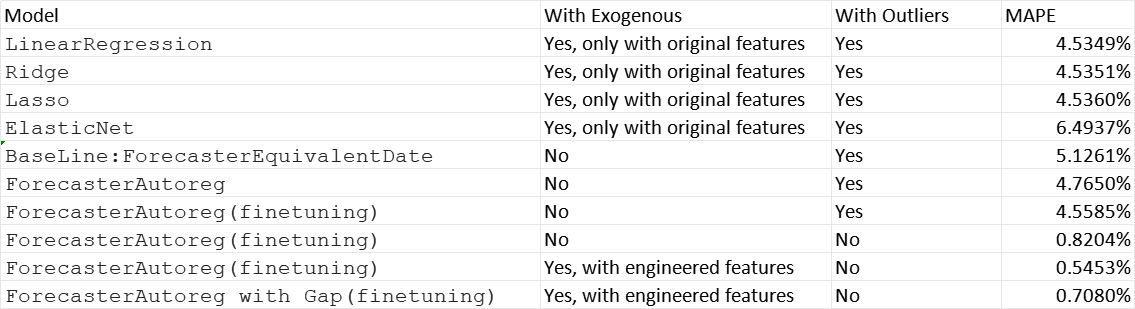